## Baseball Stats

In [57]:
import os
import sqlite3 as sql
import logging

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

from scrapers import fangraph
import bb_stat_utils

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', level=logging.INFO)
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline


In [58]:
# Point to the SQLLTIE Db
db_path = r'/home/zach/dev/demos/2021_Baseball_PURE.db'
if not os.path.exists(db_path):
    #This may take a while (~30 mins)
    fangraphscraper = fangraph.FangraphScraper(db_path)
    fangraphscraper.generate_sqllite_tables()
conn = sql.connect(db_path)

In [59]:
df = pd.read_sql('SELECT BO, RBI, PA FROM BAT WHERE "POS"!="P" AND "POS"!="PH" AND PA!=0', con = conn)
df = df.astype(int)

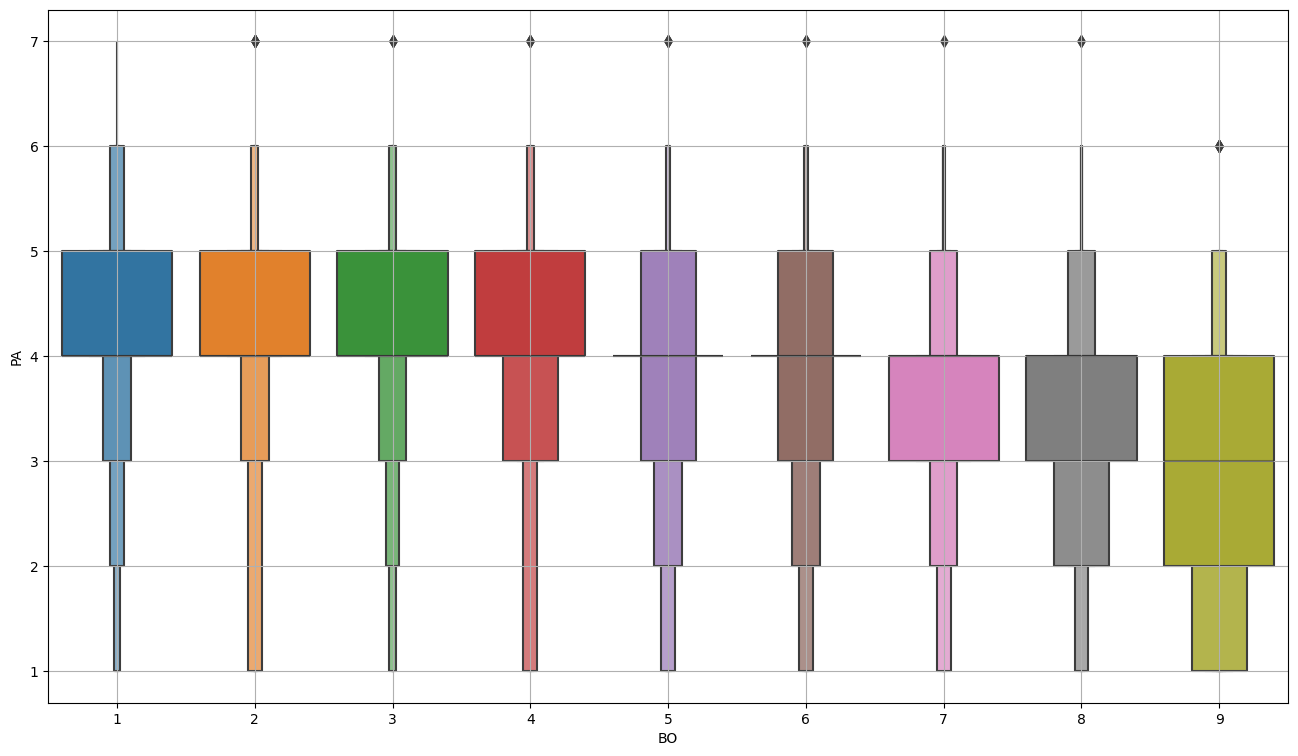

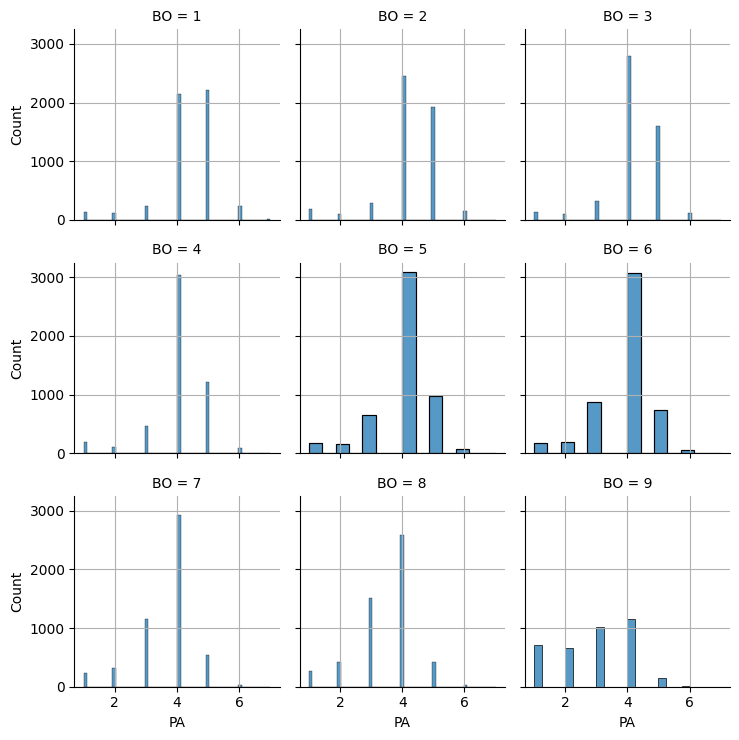

In [60]:
fgi, ax = plt.subplots(figsize=(16,9))
sns.boxenplot(data=df, x='BO', y='PA', ax=ax)
ax.grid()

g = sns.FacetGrid(df, col="BO", height=2.5, col_wrap=3)
g.map(sns.histplot, "PA")
[i.grid(True) for i in g.axes];

In [61]:
# KS Test For Normality
for i in np.arange(1000, 10000, 1000):
    rvs = stats.norm.rvs(size=i)
    f = stats.kstest(rvs, "norm")
    print(i, f.pvalue)

1000 0.075396435091443
2000 0.5081816753102552
3000 0.37429166234142297
4000 0.13914080341701596
5000 0.3272442139849773
6000 0.6506036833765777
7000 0.7690808209773977
8000 0.6855587608643177
9000 0.15682556335818243


In [62]:
# LOOKS PROMSING
dist_df = df[['PA', 'BO']].groupby('BO').describe()
idx = pd.IndexSlice
x = np.random.normal(*dist_df.loc[:, idx['PA', ['mean', 'std']]].values.T,size=(10000,9))
cont_df = pd.DataFrame(x,columns=range(1,10))
flat_cont_df = cont_df.melt(var_name='BO',value_name='PA')

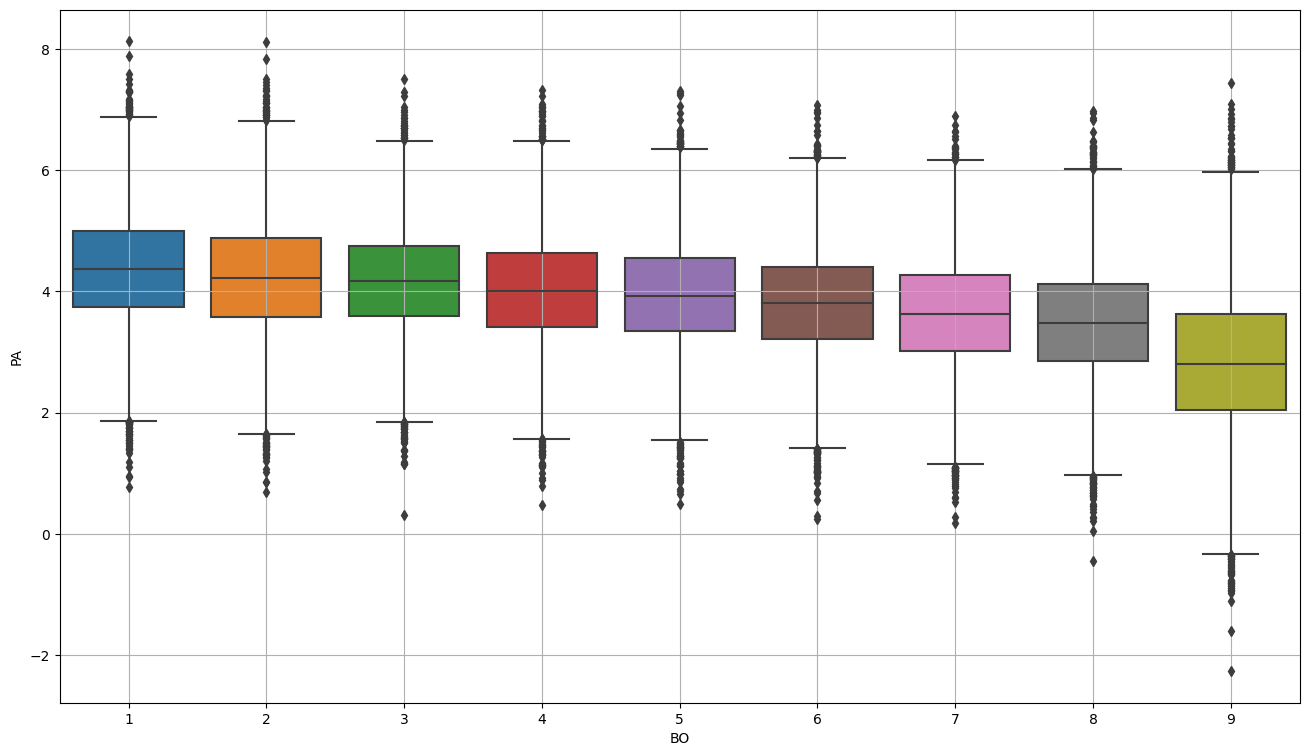

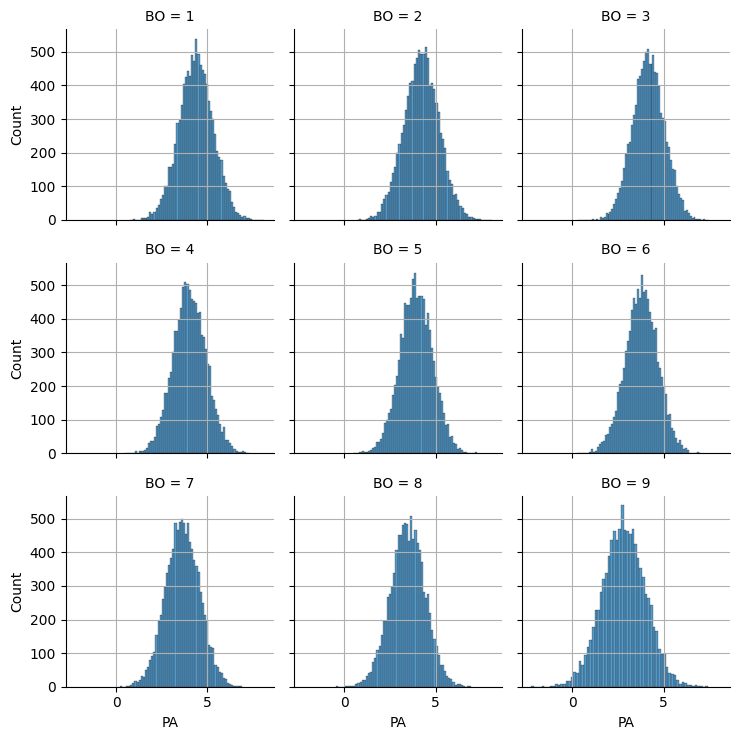

In [63]:
fgi, ax = plt.subplots(figsize=(16,9))
sns.boxplot(data=flat_cont_df, x='BO', y='PA', ax=ax)
ax.grid()

g = sns.FacetGrid(flat_cont_df, col="BO", height=2.5, col_wrap=3)
g.map(sns.histplot, "PA")
[i.grid(True) for i in g.axes];

1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0


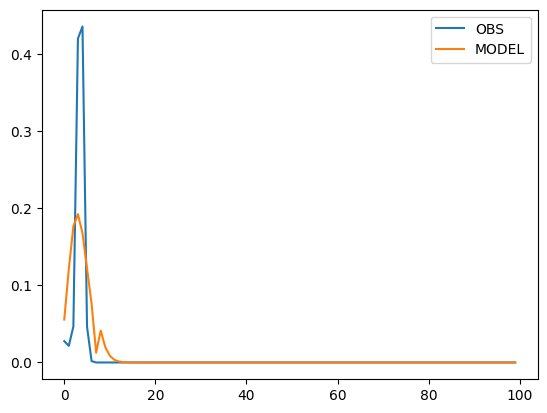

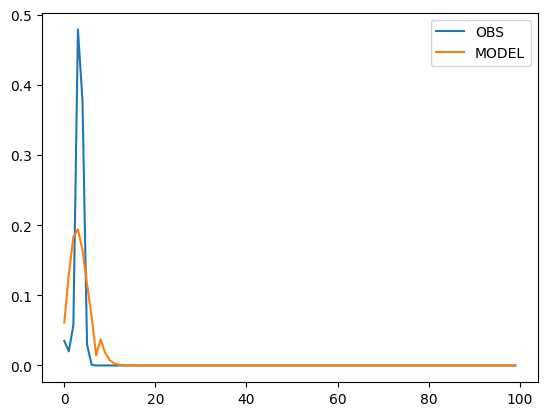

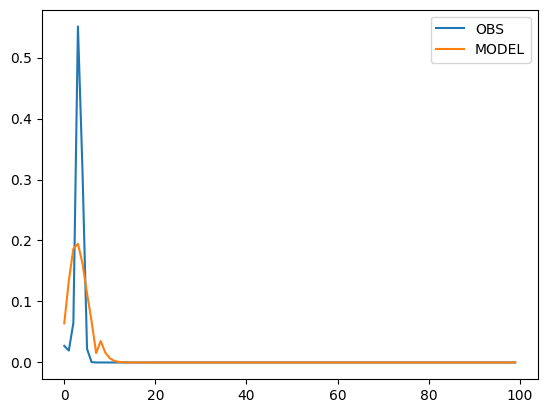

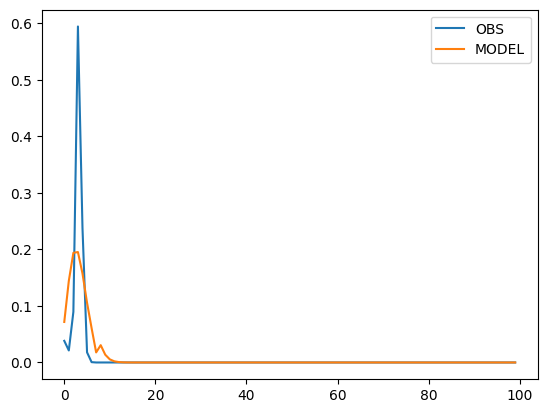

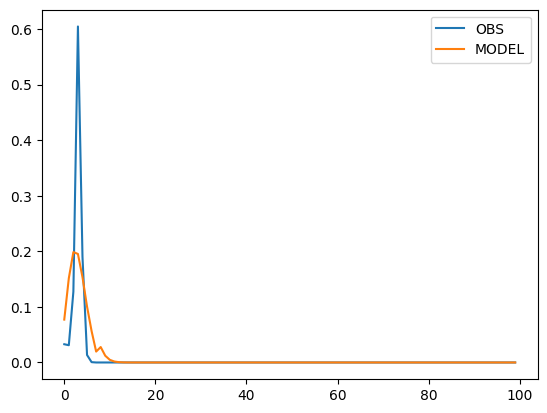

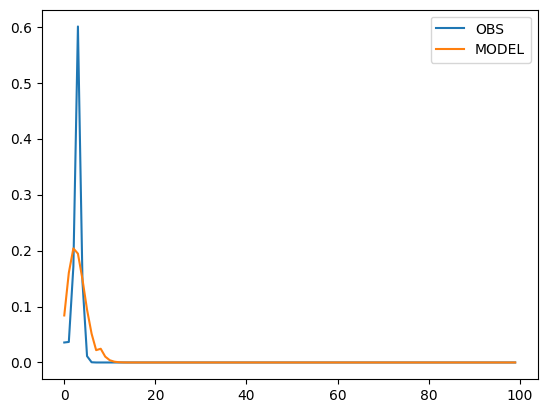

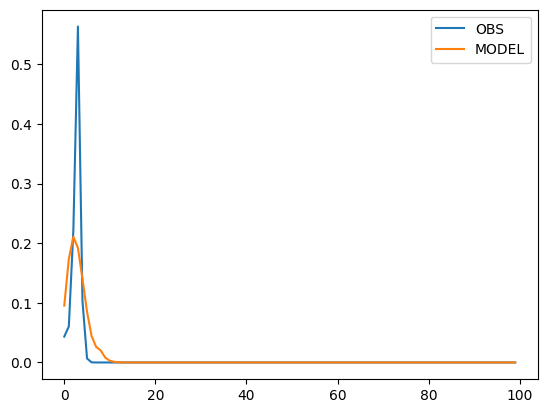

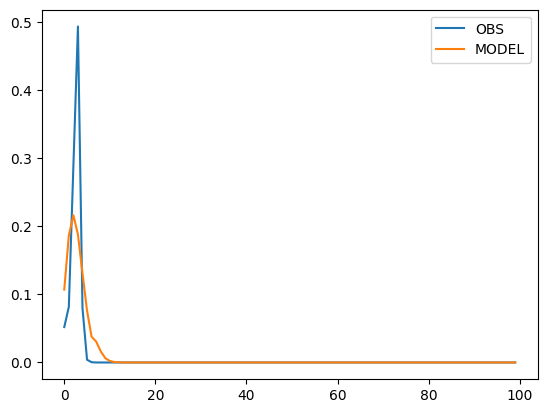

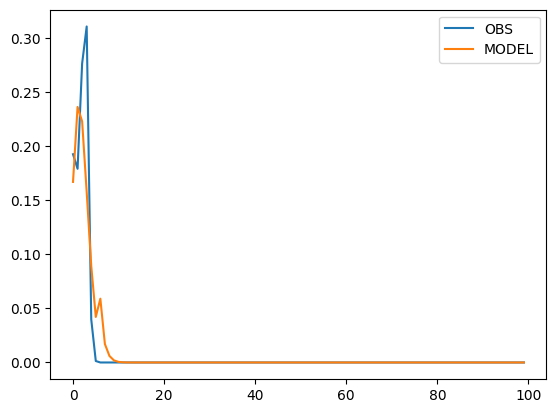

In [64]:
# POISON DOESNT MODEL IT WELL
dfg_obs_counts = df.groupby(['BO'])['PA'].value_counts() 
dfg_obs_mean = df.groupby(['BO'])['PA'].mean() 
for i in range(1, 10): 

    # Add Extra Values So the Chi-Swaured is Happy (Need to include obscene PA totals ie 100)
    obs_index = dfg_obs_counts.loc[idx[i,:]].sort_index().index.values
    extra_index_values = np.array([0] + list(range(obs_index[-1] + 1, 100)))
    obs_index =  obs_index = np.hstack([obs_index, extra_index_values])

    obs = dfg_obs_counts.loc[idx[i,:]].sort_index().values
    extra_obs_values =  np.zeros(extra_index_values.shape, dtype=int)
    obs = np.hstack([obs, extra_obs_values])
    obs_norm = obs / obs.sum()

    # Create the Poisson Model
    p = stats.poisson(dfg_obs_mean.loc[i])
    # Obtain the PMF of the model at the points of interest
    model_sample = p.pmf(obs_index)

    f = stats.chisquare(f_obs=obs_norm, f_exp=model_sample)
    print(i, f.pvalue)
    plt.figure()
    plt.plot(obs_norm, label='OBS')
    plt.plot(model_sample, label='MODEL')
    plt.legend()